## **CROHME Temporal Sequence Classification (CROHME-CTC) Baseline**

### Dependencies

Run the following command to install the required dependencies:

```bash
!pip install -q -r requirements.txt
```

In [71]:
# !pip install -q -r requirements.txt  TODO: export requirements.txt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import numpy as np
import os

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import xml.etree.ElementTree as ET
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt

### Task 1: Build Vocabulary

In this task, we will build a vocabulary from all dataset files _(train, valid, and test)_. The vocabulary will be used to convert the characters in the data to integers.

The vocabulary will then be used in the next task to convert the characters in the data to integers.

> _You can either save the vocabulary into a JSON file, or you can simply pass into the dataset as an argument._

***Input***: the path to the dataset files _(train, valid, and test)_.


```python
paths = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]
```

***Output***: the vocabulary.

```python
vocab = {
    "a": 0,
    "b": 1,
    "c": 2,
    ...
}
```

#### Understand the Data

Let's first inspect our dataset files.

In [ ]:
paths = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]  # adjust this based on your dataset location

for path in paths:
    with open(path, "r") as f:
        data = f.readlines()
        print(type(data), len(data), end="\n")
        print(data, end="\n\n")

Base on the observation, how can we build a vocabulary from the dataset files?

#### Build Vocabulary

> **TASK: IMPLEMENT `get_unique_chars(path)` and `get_char2idx(unique_chars)`.**


***Hints:***
 - *Understand the structure/format in each line.*
 - *Iterate through our data and get **unique** characters for our vocabulary.*

In [ ]:
def get_unique_chars(paths) -> set:
    # Your code here
    pass


def get_char2idx(unique_chars) -> dict:
    # Your code here
    pass


assert len(get_unique_chars(paths)) == 109  # 109 unique characters in the dataset

### Task 2: Build Dataset

In this task, we will build a dataset class that will be used to load the dataset files _(train, valid, and test)_.

The dataset class will also be used to preprocess the data by converting the characters in the data to integers using the vocabulary.

> _Before going to this task, it is **highly recommended** to read this [Tutorial on creating Custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) with PyTorch._
>
> _You should have basic understanding of required methods in the Dataset class such as `__init__`, `__len__`, and `__getitem__`._


***Input***: Dataset class should take the following arguments:.

- `annotation`: the path to the dataset annotation *(`.txt`)*.
- `root_dir`: the root directory of the dataset file.
- `vocab`: the vocabulary.

***Output***: the dataset class.

> *Note: You can adjust the Dataset class base on your references.*


#### Handle Inkml Files

Below is a class structure for handling `.inkml` files.

In [74]:
class Segment(object):
    """Class to reprsent a Segment compound of strokes (id) with an id and label."""

    __slots__ = ("id", "label", "strId")

    def __init__(self, *args):
        if len(args) == 3:
            self.id = args[0]
            self.label = args[1]
            self.strId = args[2]
        else:
            self.id = "none"
            self.label = ""
            self.strId = set([])


class Inkml(object):
    """Class to represent an INKML file with strokes, segmentation and labels"""

    __slots__ = ("fileName", "strokes", "strkOrder", "segments", "truth", "UI")

    NS = {
        "ns": "http://www.w3.org/2003/InkML",
        "xml": "http://www.w3.org/XML/1998/namespace",
    }

    def __init__(self, *args):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if len(args) == 1:
            self.fileName = args[0]
            self.loadFromFile()

    def fixNS(self, ns, att):
        """Build the right tag or element name with namespace"""
        return "{" + Inkml.NS[ns] + "}" + att

    def loadFromFile(self):
        """load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        # # ET.register_namespace();
        root = tree.getroot()
        for info in root.findall("ns:annotation", namespaces=Inkml.NS):
            if "type" in info.attrib:
                if info.attrib["type"] == "truth":
                    self.truth = info.text.strip()
                if info.attrib["type"] == "UI":
                    self.UI = info.text.strip()
        for strk in root.findall("ns:trace", namespaces=Inkml.NS):
            self.strokes[strk.attrib["id"]] = strk.text.strip()
            self.strkOrder.append(strk.attrib["id"])
        segments = root.find("ns:traceGroup", namespaces=Inkml.NS)
        if segments is None or len(segments) == 0:
            return
        for seg in segments.iterfind("ns:traceGroup", namespaces=Inkml.NS):
            id = seg.attrib[self.fixNS("xml", "id")]
            label = seg.find("ns:annotation", namespaces=Inkml.NS).text
            strkList = set([])
            for t in seg.findall("ns:traceView", namespaces=Inkml.NS):
                strkList.add(t.attrib["traceDataRef"])
            self.segments[id] = Segment(id, label, strkList)

    def getTraces(self, height=256):
        traces_array = [
            np.array(
                [p.strip().split() for p in self.strokes[id].split(",")], dtype="float"
            )
            for id in self.strkOrder
        ]

        ratio = height / (
            (
                np.concatenate(traces_array, 0).max(0)
                - np.concatenate(traces_array, 0).min(0)
            )[1]
            + 1e-6
        )
        return [(trace * ratio).astype(int).tolist() for trace in traces_array]

`Inkml` class is used to read an inkml file and extract the strokes and the corresponding label.

***Input***: the path to the inkml file.

***Output***: Inkml object that can be used to extract the strokes.

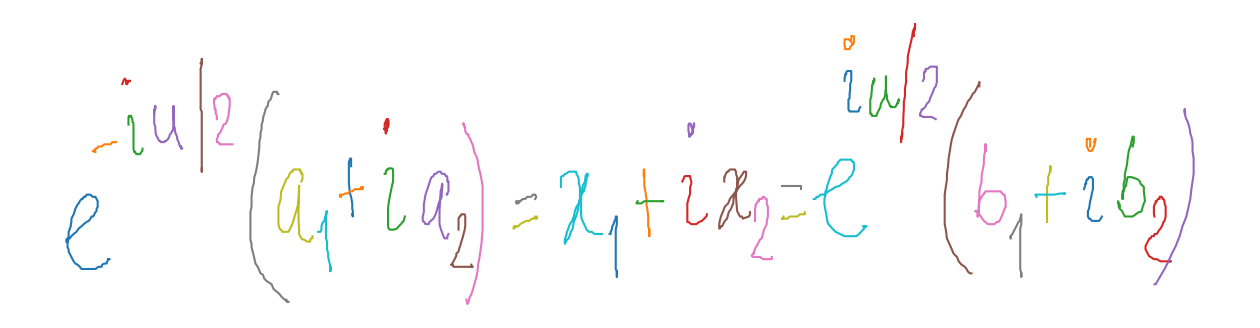

In [73]:
def visualize_inkml(ink_obj: Inkml):
    ink = ink_obj

    plt.figure(figsize=(16, 4))
    plt.axis("off")
    for trace in ink.getTraces():
        trace_arr = np.array(trace)
        plt.plot(trace_arr[:, 0], -trace_arr[:, 1])  # invert y coordinate


path = "dataset/crohme2019/crohme2019/test/ISICal19_1201_em_758.inkml"
ink = Inkml(path)
visualize_inkml(ink)

> **TASK: UNDERSTAND AND HANDLE OUTPUT OF `getTraces()` METHOD IN `Inkml` CLASS.**

In [ ]:
ink = Inkml(path)
[np.array(trace).shape for trace in ink.getTraces()]  # [(n, 2), (n, 2), ...]

**WARNING**: _Some Inkml may return (x, y, t) coordinates, while others may return (x, y) coordinates. Make sure to handle this in your implementation._

Now you have the idea of how to read an inkml file, let's build the Dataset class.

#### Build Dataset

Base on the observation, how can we build a dataset class from the dataset files?

***Hints:***
   - *Understand the big picture. (Data --> Dataset --> DataLoader --> Model --> Output --> Calculate Loss --> Backpropagation)*
   - *What do our model expect to get? In other words, what information is being fed into our model to calculate the loss?*
   - *What informations needed to calculate our Loss?*
   - *What should be returned in the `__getitem__` method?*
   - *The outputs should be of Tensor type*


> **TASK: IMPLEMENT `InkmlDataset` CLASS.**

In [ ]:
class InkmlDataset(Dataset):
    def __init__(self, annotation: str, root_dir: str, vocab: dict):
        # Your code here
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab

        self.inks = []  # list of Inkml objects
        self.labels = []  # list of labels

        # Your code for create self.inks and self.labels from the annotation file

    def __len__(self):
        # This code should return the number of samples in the dataset
        pass

    def __getitem__(self, idx):
        # This code should return the idx-th sample in the dataset

        pass

#### Feature representation

In this subtask, we will convert the strokes into feature representations that can be used by the model.

Initially, the `.getTraces()` method returns list of strokes, where each stroke is a list of (x, y) coordinates. Intuitively, we can use those coordinates as features. But if we directly use the coordinates, the model will have a hard time learning the patterns.

Instead, we can calculate the difference *(∆d)* between consecutive coordinates as features. This way, the model can learn the patterns more easily.

```
point 1: (x1, y1)
point 2: (x2, y2)
point 3: (x3, y3)
...
point n: (xn, yn)
```

The feature representation will be:

```
∆d1 = (x2 - x1, y2 - y1)
∆d2 = (x3 - x2, y3 - y2)
∆d3 = (x4 - x3, y4 - y3)
...
∆dn-1 = (xn - xn-1, yn - yn-1)
```

> **TASK: CALCULATE `(∆X, ∆Y)` FOR INPUT FEATURE.**

#### Pen-up and Pen-down

In the dataset, each stroke is separated by a pen-up event. We can use this information to separate the strokes.

1. **Pen-up [0]**: The pen is lifted from the paper.
2. **Pen-down [1]**: The pen is on the paper.

Use this information to separate the strokes.

> **TASK: ADD FEATURE `pen_up_down` TO `(∆X, ∆Y)` -> `(∆X, ∆Y, pen_up_down)`**

### Task 3: Build DataLoader

In this task, we will build a DataLoader that will be used to load the dataset.

> _Before going to this task, it is **highly recommended** to read this [Prepare your data for training with DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)._


***Input***: DataLoader class should take the following arguments:

- `dataset`: the dataset class.
- `batch_size`: the batch size.
- `shuffle`: whether to shuffle the data.
- `num_workers`: the number of workers to load the data.
- `collate_fn`: custom function to collate the data.

***Output***: the DataLoader class.

> *Note: You don't need to redefine DataLoader class. However, you need to redefine its collate function.*

#### Custom Collate Function

A collate function is used in PyTorch's DataLoader to define how individual samples from a dataset should be combined into a batch. 

By default, the DataLoader assumes that each sample is a tensor, and it concatenates them along a new dimension to form a batch. However, if the samples have varying sizes, such as in the case of sequences of different lengths, we need a custom collate function to handle this.

To handle sequences of different lengths, one common approach is to use the `pad_sequence` function from PyTorch. `pad_sequence` pads the sequences with zeros to make them of equal length, ensuring that they can be stacked into a batch.

> _You can read more about [pad_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html). to implement our `custom_collate_fn()`._

> **TASK: IMPLEMENT `custom_collate_fn(batch)` FUNCTION.**

In [77]:
def custom_collate_fn(batch):
    # Your code here
    pass

#### Create DataLoader

From the dataset class, how can we build a DataLoader with custom collate function?

> **TASK: IMPLEMENT `get_dataloader()` FUNCTION.**

***Hints:***
 - `DataLoader` class takes the dataset, batch size, shuffle, number of workers, and collate function as arguments.
    - `collate_fn` argument should be a function that defines how to combine individual samples into a batch.

In [ ]:
def get_dataloader() -> DataLoader:
    # Your code here
    pass

### (EXTRA) Task: Build Dataset and DataLoader with PyTorch Lightning

In this subtask, we will build the Dataset and DataLoader using PyTorch Lightning.

The `pl.LightningDataModule` class should define methods for setting up the data, creating data loaders, and handling data collation. Here's a brief overview of the expected behavior of the `pl.LightningDataModule`:

- Data Setup: The setup method is responsible for any necessary setup steps before training, validation, or testing. This can include downloading datasets, preprocessing data, or any other data-related initialization. It is called automatically by PyTorch Lightning.

- Data Collation: The `custom_collate_fn` method is used to define a custom collation function for the data. This function is responsible for combining individual data samples into batches. It is called by the data loaders during training, validation, and testing.

- Data Loaders: The `train_dataloader`, `val_dataloader`, and `test_dataloader` methods are used to create data loaders for training, validation, and testing, respectively. These methods should return instances of `torch.utils.data.DataLoader` that provide batches of data to the model during training and evaluation.

> _You can read more about [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/)._

> **TASK: IMPLEMENT `InkmlDataModule` CLASS.**

In [ ]:
class InkmlDataset_PL(pl.LightningDataModule):
    """
    Pytorch Lightning DataModule for the InkmlDataset.
    """
    def __init__(
        self,
        batch_size: int = 10,
        workers: int = 5,
        train_data: str = "dataset/crohme2019_train.txt",
        val_data: str = "dataset/crohme2019_valid.txt",
        test_data: str = "dataset/crohme2019_test.txt",
        root_dir: str = "dataset",
    ):
        super().__init__()
        self.batch_size = batch_size
        self.workers = workers
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.root_dir = root_dir

    def setup(self, stage=None):
        # Your code here
        pass

    def custom_collate_fn(self, data):
        # Your code here
        pass

    def train_dataloader(self) -> DataLoader:
        pass

    def val_dataloader(self) -> DataLoader:
        pass

    def test_dataloader(self) -> DataLoader:
        pass

